In [8]:
import numpy as np

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10

NUM_CLASS = 10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, NUM_CLASS)
y_test = to_categorical(y_test, NUM_CLASS)

170500096/170498071 [==============================] - 45s 0us/step


In [10]:
x_train.shape

(50000, 32, 32, 3)

In [11]:
y_train.shape

(50000, 10)

In [21]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [22]:
x_train[54, 12, 13, 1]

0.36862746

In [24]:
# Sequential モデルを用いた構造（easy だが複雑なネットワークの記述に適さない）
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

seq_model = Sequential([
    Dense(200, activation = 'relu', input_shape=(32, 32, 3)),
    Flatten(),
    Dense(150, activation = 'relu'),
    Dense(10, activation = 'softmax'),
])

In [25]:
print(seq_model)

In [26]:
# Functional API を用いた構造
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

# バッチサイズを指定していない
# Input 層には任意の枚数の画像を一度に渡すことができるため、バッチサイズは不要
input_layer = Input(shape=(32, 32, 3))

# 次に、入力を Flatten 層で平坦化、つまりベクトルにする
# この結果、長さ 3072 (= 32*32*3) のベクトルが得られる。
# これを行っているのは、続く Dense 層の入力が複数次元の配列ではなく 1 次元だから。
# なお、これ以外の層は入力として複数次元の配列を必要とする。
x = Flatten()(input_layer)
print(f'Flatten 後の shape: {x.shape}')

# この層のノードはすべて前の層の全ノードと接続されており、1 つの接続は 1 つの重みを持つ。
# あるノードからの出力は、そのノードが前の層から受け取った入力の加重和を必携の活性化関数に通したものになる。
# 以下は、x = Dense(units=200)(x); x = Activation('relu')(x) のように分けて書くこともできる。
x = Dense(units=200, activation = 'relu')(x)
x = Dense(units=150, activation = 'relu')(x)

# cifar10 は 10 個のカテゴリへの分類だから、出力のノード数は 10
output_layer = Dense(units=10, activation = 'softmax')(x)

model = Model(input_layer, output_layer)

Flatten 後の shape: (None, 3072)


In [27]:
# モデルの概要を確認する
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               614600    
_________________________________________________________________
dense_4 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1510      
Total params: 646,260
Trainable params: 646,260
Non-trainable params: 0
_________________________________________________________________


In [32]:
# モデルをコンパイルする
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=0.0005)
# 損失関数（loss）は予測結果と正解を比較するのに用いられる
# 回帰問題 -> 平均二乗誤差
# 多クラス分類問題（それぞれの観測が 1 つのクラスにだけ属する）-> 多クラス交差エントロピー
# 2 値分類問題や、それぞれの観測が複数のクラスに属する可能性のある多ラベル問題 -> 2 値交差エントロピー
# TODO: 多クラス交差エントロピーと 2 値交差エントロピーの違い、使い分けを明瞭に説明できるか？
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [33]:
# モデルを訓練する
# batch_size: 各訓練ステップで何個の観測をこのネットワークに渡すか
# epoch: このネットワークに何回、全トレーニングデータを渡すか
# shuffle: True の場合、バッチは各観測ステップで訓練データからランダムに重複なく取り出される
model.fit(x_train, y_train, batch_size=32, epochs=10, shuffle=True)

Epoch 1/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.8470 - accuracy: 0.3345
Epoch 2/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.6668 - accuracy: 0.4056
Epoch 3/10
1563/1563 [==============================] - 3s 2ms/step - loss: 1.5903 - accuracy: 0.4345
Epoch 4/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.5405 - accuracy: 0.4508
Epoch 5/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.4932 - accuracy: 0.4693
Epoch 6/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.4639 - accuracy: 0.4781
Epoch 7/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.4338 - accuracy: 0.4914
Epoch 8/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.4089 - accuracy: 0.4997
Epoch 9/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.3903 - accuracy: 0.5044
Epoch 10/10
1563/1563 [==============================] - 4s 2ms/step - loss: 1.368

In [34]:
# モデルを評価する
# 上記で指定した尺度（多クラス交差エントロピーと accuracy）を一覧表示したものが表示される。
model.evaluate(x_test, y_test)


313/313 [==============================] - 0s 816us/step - loss: 1.4321 - accuracy: 0.4955


[1.4321190118789673, 0.49549999833106995]

In [38]:
# predict メソッドを使って実際の予測を見てみる
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

In [39]:
print(preds_single)
print(actual_single)

['cat' 'ship' 'ship' ... 'dog' 'bird' 'horse']
['cat' 'ship' 'ship' ... 'dog' 'automobile' 'horse']


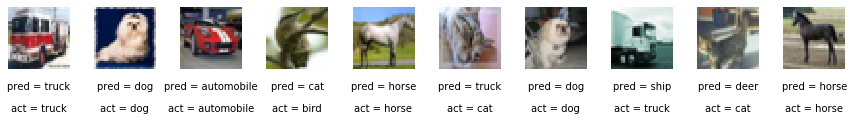

In [50]:
# 以下のプログラムで、いくつかの画像と、そのラベルと予測を並べて表示できる
import matplotlib.pyplot as plt

n_to_show = 10
indices = np.random.choice(len(x_test), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.7, 'act = ' + str(actual_single[idx]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)